In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from kafe2 import XYFit, Plot,  ContoursProfiler, XYContainer, Fit, Plot
import uncertainties as unc
from uncertainties import unumpy
from scipy.signal import find_peaks

# Gamma spectrum

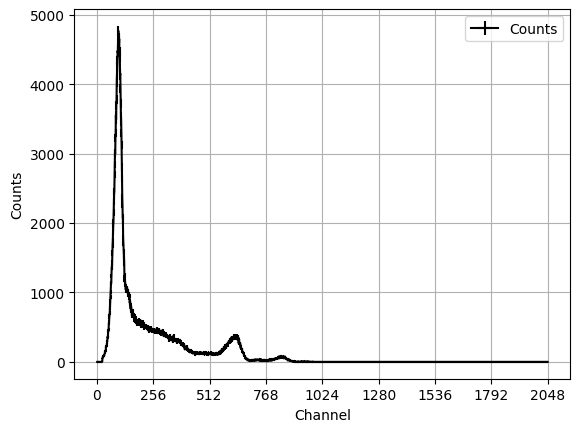

In [2]:
# load data entire gamma spectrum
channel_gam, counts_gam = np.loadtxt('PCA3-ADC_gamma_spec_all.RPT', unpack=True)
plt.errorbar(channel_gam, counts_gam, yerr=np.sqrt(counts_gam), xerr=1, c='black', label=r'Counts')
plt.xlabel('Channel')
plt.ylabel('Counts')
plt.xticks([0, 256, 512, 768, 1024, 1280, 1536, 1792, 2048])
plt.grid(True)
plt.legend()
#plt.savefig('A1_gamma_all.pdf', bbox_inches='tight')
plt.show()

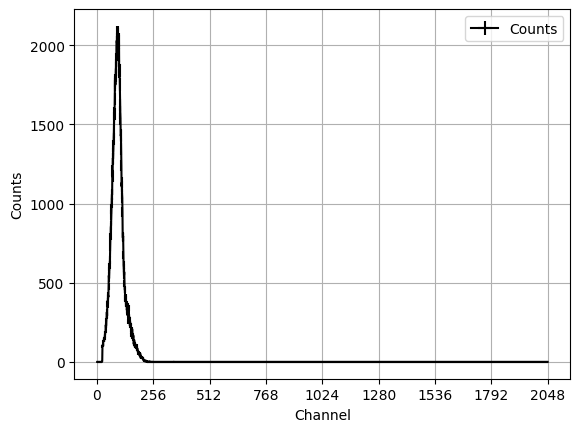

In [3]:
# load data selected gamma spectrum
channel_gam, counts_gam = np.loadtxt('PCA3-ADC_gamma_selected.RPT', unpack=True)
plt.errorbar(channel_gam, counts_gam, yerr=np.sqrt(counts_gam), xerr=1, c='black', label='Counts')
plt.xlabel('Channel')
plt.ylabel('Counts')
plt.xticks([0, 256, 512, 768, 1024, 1280, 1536, 1792, 2048])
plt.grid(True)
plt.legend()
#plt.savefig('A1_gamma_selected.pdf', bbox_inches='tight')
plt.show()

# Velocity Calibration

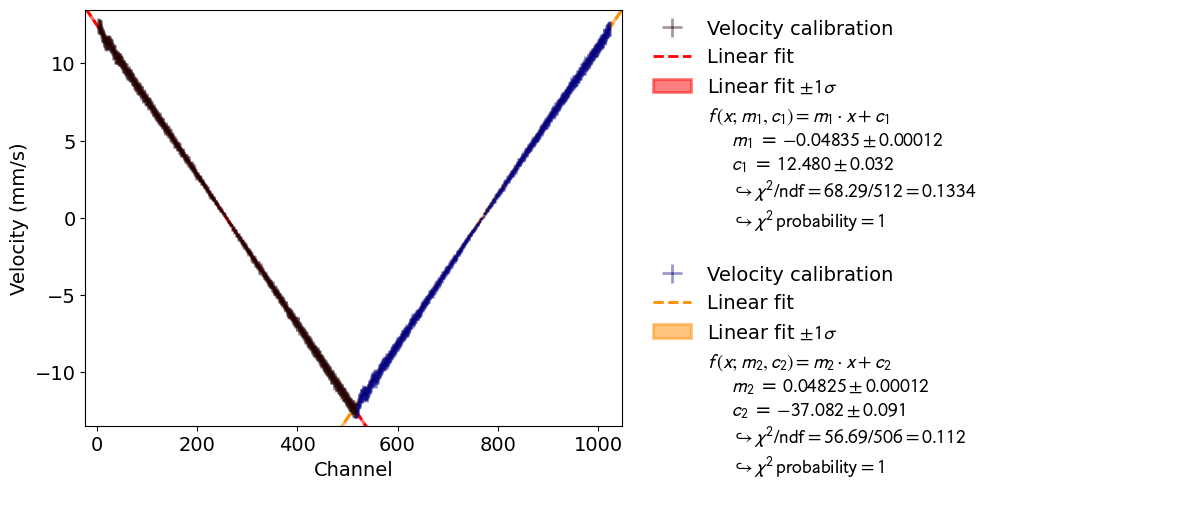

In [4]:
# load data
channel, counts = np.loadtxt('PCA3-MCS_velocity.RPT', unpack=True)
#plt.scatter(channel[2:], counts[2:], c='black')


# determine knicks
knick_max = np.mean(channel[counts==np.max(counts[2:])])
knick_min1 = np.mean(channel[(counts==0) & (channel<knick_max)])
knick_min2 = np.mean(channel[(counts==0) & (channel>knick_max)])
#print(knick_min1, knick_max)

# get velocity from counts
BZ = counts[1] * 10e-6 # micro s
lam = 650e-9 #m
v = lam / 2 * counts / BZ * 1000 #mm/s

# Define the model function for the fit
def lin_fit(x, m, c):
    return m * x + c

# set data 1
y1 = np.array([])
x1 = channel[(channel>2) & (channel<=knick_max)]-0.5
y1 = np.append(y1, v[(channel>2) & (channel<=knick_min1)])
y1 = np.append(y1, -v[(channel>knick_min1) & (channel<=knick_max)])
xerr1 = 1
yerr1 = lam / 2 * np.sqrt(np.abs(counts[(channel>2) & (channel<=knick_max)])) / BZ * 1000 #mm/s

# Define the fit1
fit1 = XYFit(xy_data = [x1, y1], model_function = lin_fit)
fit1.add_error(axis = 'y', err_val = yerr1)
fit1.add_error(axis = 'x', err_val = xerr1)

# Optional1: Assign LaTeX expressions to the function and its variables.
fit1.assign_parameter_latex_names(m='m_1', x='x',c="c_1")
fit1.assign_model_function_latex_expression("{m} \cdot x+{c}")
fit1.assign_model_function_latex_name("f\,")
fit1.model_label = "Linear fit"
fit1.data_container.label = 'Velocity calibration'
fit1.data_container.axis_labels = ['Channel', 'Velocity (mm/s)']
 
fit1.do_fit()


# set data 2
y2 = np.array([])
x2 = channel[channel>knick_max]-0.5
y2 = np.append(y2, -v[(channel>knick_max) & (channel<=knick_min2)])
y2 = np.append(y2, v[channel>knick_min2])
xerr2 = 1
yerr2 = lam / 2 * np.sqrt(np.abs(counts[(channel>knick_max)])) / BZ * 1000 #mm/s

# Define the fit 2
fit2 = XYFit(xy_data = [x2, y2], model_function = lin_fit)
fit2.add_error(axis = 'y', err_val = yerr2)
fit2.add_error(axis = 'x', err_val = xerr2)


# Optional: Assign LaTeX expressions to the function and its variables.
fit2.assign_parameter_latex_names(m='m_2', x='x',c="c_2")
fit2.assign_model_function_latex_expression("{m} \cdot x+{c}")
fit2.assign_model_function_latex_name("f\,")
fit2.model_label = "Linear fit"
fit2.data_container.label = 'Velocity calibration'
fit2.data_container.axis_labels = ['Channel', 'Velocity (mm/s)']

fit2.do_fit()



# Finaly plot the fit
plot = Plot([fit1, fit2])
plot.y_range = (-np.max(v[2:])-1, np.max(v[2:])+1)
plot.customize('model_line', 'color', [(0, 'red'), (1, 'darkorange')])
plot.customize('model_error_band', 'color', [(0, 'red'), (1, 'darkorange')])
plot.customize('data', 'marker', [(0, '.'), (1,'.')])
plot.customize('data', 'markersize', [(0, 2), (1, 2)])
plot.customize('data', 'alpha', [(0, 0.4), (1, 0.4)])
plot.plot()

# and show everything
#plt.savefig("VelocityCalibration.pdf", bbox_inches='tight')
plt.show()


In [5]:
# get fit parameters
m1, c1 = unumpy.uarray(fit1.parameter_values, fit1.parameter_errors)
m2, c2 = unumpy.uarray(fit2.parameter_values, fit2.parameter_errors)


# function velocity
def velocity(channel, knick, m1, c1, m2, c2):
    channel_n = unumpy.uarray(channel, np.ones(len(channel)))
    v = np.array([])
    verr = np.array([])
    v1 = m1 * channel_n[:int(knick)] + c1
    v2 = m2 * channel_n[int(knick):] + c2
    v = np.append(v, unumpy.nominal_values(v1))
    verr = np.append(verr, unumpy.std_devs(v1))
    v = np.append(v, unumpy.nominal_values(v2))
    verr = np.append(verr, unumpy.std_devs(v2))
    return unumpy.uarray(v, verr)

v = velocity(channel[2:], knick_max, m1, c1, m2, c2)


# Data loading

In [6]:
#load data Vacromium
channel_Va, counts_Va = np.loadtxt(f'PCA3-MCS_Vacromium.RPT', unpack=True)
# counts into velocities
v_Va = unumpy.nominal_values(velocity(channel_Va, knick_max, m1, c1, m2, c2))
v_Va_err = unumpy.std_devs(velocity(channel_Va, knick_max, m1, c1, m2, c2))
df_Va = pd.DataFrame(data={'Channel_err': np.ones(len(channel_Va)), 'Counts': counts_Va, 'Counts_err': np.sqrt(counts_Va), 'Velocity': v_Va, 'Velocity_err': v_Va_err})

#load data Iron
channel_Fe, counts_Fe = np.loadtxt(f'PCA3-MCS_Iron.RPT', unpack=True)
# counts into velocities
v_Fe = unumpy.nominal_values(velocity(channel_Fe, knick_max, m1, c1, m2, c2))
v_Fe_err = unumpy.std_devs(velocity(channel_Fe, knick_max, m1, c1, m2, c2))
df_Fe = pd.DataFrame(data={'Channel_err': np.ones(len(channel_Fe)), 'Counts': counts_Fe, 'Counts_err': np.sqrt(counts_Fe), 'Velocity': v_Fe, 'Velocity_err': v_Fe_err})

#load data FePO4
channel_FePO4, counts_FePO4 = np.loadtxt(f'PCA3-MCS_FePO4.RPT', unpack=True)
# counts into velocities
v_FePO4 = unumpy.nominal_values(velocity(channel_FePO4, knick_max, m1, c1, m2, c2))
v_FePO4_err = unumpy.std_devs(velocity(channel_FePO4, knick_max, m1, c1, m2, c2))
df_FePO4 = pd.DataFrame(data={'Channel_err': np.ones(len(channel_FePO4)), 'Counts': counts_FePO4, 'Counts_err': np.sqrt(counts_FePO4), 'Velocity': v_FePO4, 'Velocity_err': v_FePO4_err})

#load data FeSO4
channel_FeSO4, counts_FeSO4 = np.loadtxt(f'PCA3-MCS_FeSO4.RPT', unpack=True)
# counts into velocities
v_FeSO4 = unumpy.nominal_values(velocity(channel_FeSO4, knick_max, m1, c1, m2, c2))
v_FeSO4_err = unumpy.std_devs(velocity(channel_FeSO4, knick_max, m1, c1, m2, c2))
df_FeSO4 = pd.DataFrame(data={'Channel_err': np.ones(len(channel_FeSO4)), 'Counts': counts_FeSO4, 'Counts_err': np.sqrt(counts_FeSO4), 'Velocity': v_FeSO4, 'Velocity_err': v_FeSO4_err})


# Lorentzian peak Fit function

In [7]:
# Define Lorentzian fit function
def lorentzian(ch, ch0, gamma, A):
    """
    Einzelner Lorentzian Peak.

    Args:
        ch: Kanalnummer bzw. Geschwindigkeit
        ch0: Mittelpunkt des Peaks
        gamma: full width at half maximum
        A: Skalierungsfaktor; positiv, wenn Peak nach unten zeigt

    Returns:
        Den Peak natürlich...
    """
    return -A / (1 + ((ch - ch0) / (gamma/2) )**2)

# Individuelle Modelle, weil ich zu faul war, mir was Besseres zu überlegen.
# Summe aus mehreren Peaks plus konstanter Untergrund f

def model_Fe(ch, f, p1, g1, A1, p2, g2, A2, p3, g3, A3, p4, g4, A4, p5, g5, A5, p6, g6, A6):
    return lorentzian(ch, p1, g1, A1) + lorentzian(ch, p2, g2, A2) + lorentzian(ch, p3, g3, A3) + lorentzian(ch, p4, g4, A4) + lorentzian(ch, p5, g5, A5) + lorentzian(ch, p6, g6, A6) + f

def model_FePO4(ch, f, p1, g1, A1, p2, g2, A2):
    return lorentzian(ch, p1, g1, A1) + lorentzian(ch, p2, g2, A2) + f

def model_FeSO4(ch, f, p1, g1, A1, p2, g2, A2):
    return lorentzian(ch, p1, g1, A1) + lorentzian(ch, p2, g2, A2) + f

def model_Va(ch, f, p1, g1, A1):
    return lorentzian(ch, p1, g1, A1) + f

# Mößbauer spectrum vacromium

Vacromium
[-0.26695566]
found 1 peaks
chose 1 highest peaks
Fit results:
Peak  Position             Breite              
1     -0.177  +/- 0.013    -0.364  +/- 0.021   


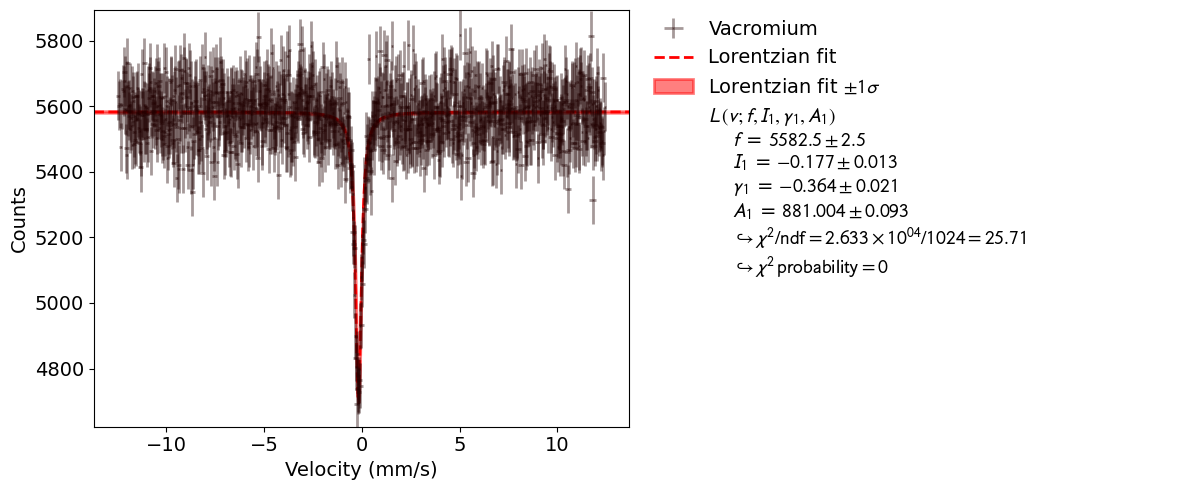

FePO$_4$
[ 0.60155125 -0.13842715]
found 2 peaks
chose 2 highest peaks
Fit results:
Peak  Position             Breite              
1     0.667   +/- 0.009    -0.429  +/- 0.030   
2     -0.116  +/- 0.015    -0.396  +/- 0.033   


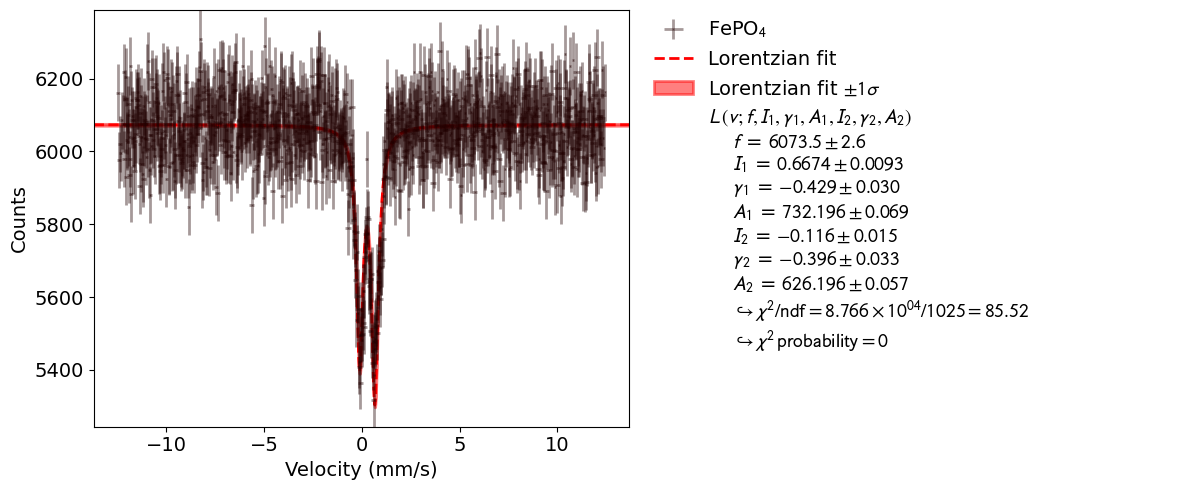

FeSO$_4$
[-0.26695566  2.62806737]
found 2 peaks
chose 2 highest peaks
Fit results:
Peak  Position             Breite              
1     -0.266  +/- 0.005    -0.243  +/- 0.022   
2     2.633   +/- 0.011    0.352   +/- 0.029   


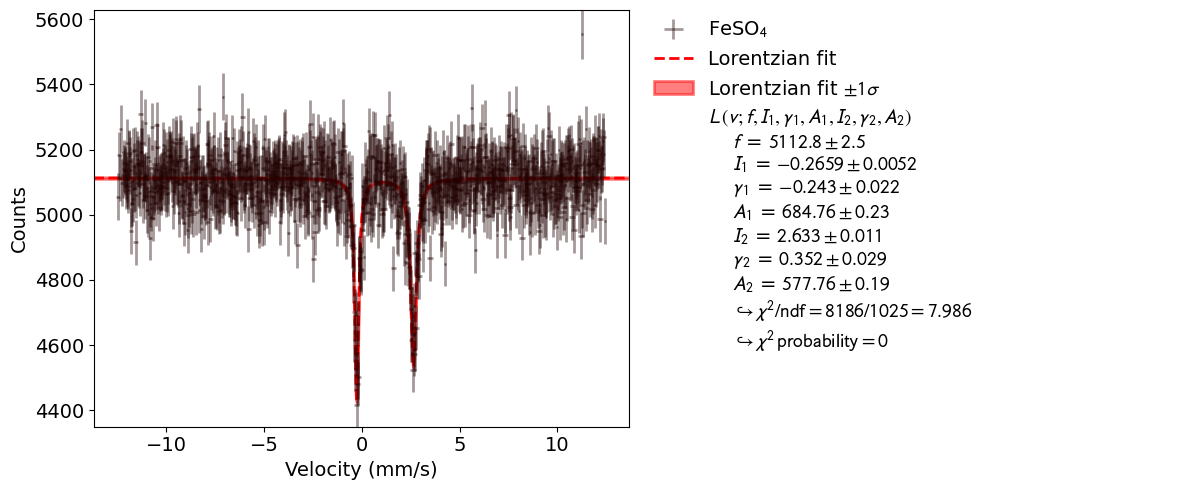

In [8]:
fit_iter = [
    ("Vacromium", df_Va, model_Va, 1),
    (r"FePO$_4$", df_FePO4, model_FePO4, 2),
    (r"FeSO$_4$", df_FeSO4, model_FeSO4, 2),
]

for name, df, model, ps in fit_iter:
    print(name)
    x = df['Velocity'].values # Geschwindigkeit
    x_err = df['Velocity_err'].values
    y = df['Counts'].values # Counts
    y_err = df['Counts_err'].values
    # Alle Peaks im Signal finden, um gute Startwerte für den Fit zu erhalten:
    peaks = find_peaks(-y, distance=30)[0]
    # Die Peaks der Höhe nach sortieren und nur die obersten ps Peaks behalten
    peaks = peaks[y[peaks].argsort()[:ps]]
    print(x[peaks])
    print(f"found {len(peaks)} peaks")
    print(f"chose {len(peaks)} highest peaks")

    # Create XYContainer
    data = XYContainer(x, y) 
    data.add_error(axis='x', err_val=x_err) 
    data.add_error(axis='y', err_val=y_err) 

    # Create Fit object
    fit = Fit(data, model)

    # Optional: Assign LaTeX expressions to the function and its variables.
    if ps == 1:
        fit.assign_parameter_latex_names(ch="v", f="f",p1="I_1",g1=r"\gamma_1",A1="A_1")
        #fit.assign_model_function_latex_expression(r"-{A1} / (1+(2(v-{p1})/{g1})^2) + {f}") #-A / (1 + ((ch - ch0) / (gamma/2) )**2)
    elif ps == 2: 
        fit.assign_parameter_latex_names(ch="v", f="f",p1="I_1",g1=r"\gamma_1",A1="A_1", p2="I_2",g2=r"\gamma_2",A2="A_2")
        #fit.assign_model_function_latex_expression(r"-{A1} / (1+(2(v-{p1})/{g1})^2) -{A1} / (1+(2(v-{p2})/{g2})^2) + {f}") #-A / (1 + ((ch - ch0) / (gamma/2) )**2)
    fit.assign_model_function_latex_name("L\,")
    fit.model_label = "Lorentzian fit"
    fit.data_container.label = f'{name}'
    fit.data_container.axis_labels = ['Velocity (mm/s)', 'Counts']
    
    # Constrain model parameters to measurements:
    for i in range(ps):
        fit.add_parameter_constraint(name=f'p{i+1}', value=df.Velocity[peaks[i]] , uncertainty=10)
        fit.add_parameter_constraint(name=f'g{i+1}', value=1,    uncertainty=1)
        fit.add_parameter_constraint(name='f', value=np.mean(y),  uncertainty=np.mean(np.sqrt(y)))
        
        if name == 'Vacromium':
            fit.limit_parameter(f'p{i+1}', lower=df.Velocity[peaks[i]]-2., upper=df.Velocity[peaks[i]]+2.)
            fit.add_parameter_constraint(name=f'A{i+1}', value=np.mean(y),  uncertainty=np.sqrt(np.mean(y)-y[peaks[i]]))
        elif name == r'FePO$_4$':
            fit.limit_parameter(f'p{i+1}', lower=df.Velocity[peaks[i]]-0.25, upper=df.Velocity[peaks[i]]+0.25)
            fit.add_parameter_constraint(name=f'A{i+1}', value=np.mean(y),  uncertainty=np.sqrt(np.mean(y)-y[peaks[i]]))
        elif name == r'FeSO$_4$':
            fit.limit_parameter(f'p{i+1}', lower=df.Velocity[peaks[i]]-0.28, upper=df.Velocity[peaks[i]]+0.28)
            fit.add_parameter_constraint(name=f'A{i+1}', value=np.mean(y)-y[peaks[i]]/1.5,  uncertainty=np.sqrt(np.mean(y)-y[peaks[i]]))
        
        fit.limit_parameter(f'A{i+1}', lower=np.mean(y)-y[peaks[i]]-10, upper=np.mean(y)-y[peaks[i]]+10)
    
    # Perform the fit
    fit.do_fit()

    print(f"Fit results:")
    print(f"{'Peak':<5} {'Position':<20} {'Breite':<20}")
    for i in range(ps):
        print(f"{i+1:<5} {fit.parameter_values[3*i+1]:<7.3f} +/- {fit.parameter_errors[3*i+1]:<8.3f} {fit.parameter_values[3*i+2]:<7.3f} +/- {fit.parameter_errors[3*i+2]:<8.3f}")

    # Create a plot of the data and the fit
    plot = Plot(fit)

    plot.customize('model_line', 'color', 'red')
    plot.customize('model_error_band', 'color', 'red')
    plot.customize('data', 'marker',  '.')
    plot.customize('data', 'markersize', 1)
    plot.customize('data', 'alpha',  0.4)
    plot.plot()
    #plt.savefig(f'A2_Moessbauer_{name}.pdf', bbox_inches='tight')
    plot.show()



Iron
[ 5.56664501  3.14924155  0.68349002 -1.05704046 -3.37774778 -5.65010703]
found 6 peaks
chose 6 highest peaks
Fit results:
Peak  Position             Breite              
1     5.544   +/- 0.012    0.332   +/- 0.028   
2     3.146   +/- 0.020    0.376   +/- 0.039   
3     0.725   +/- 0.027    -0.295  +/- 0.048   
4     -1.036  +/- 0.015    0.247   +/- 0.044   
5     -3.390  +/- 0.020    0.325   +/- 0.036   
6     -5.711  +/- 0.021    0.419   +/- 0.040   


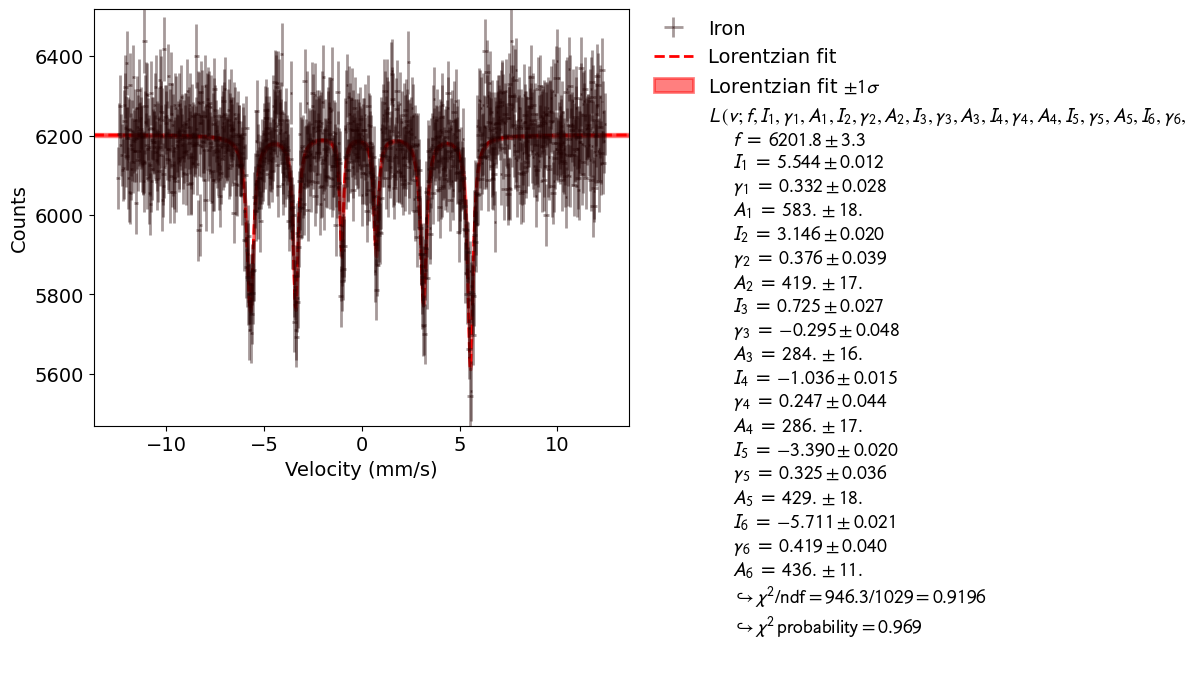

In [9]:
fit_iter = [
    #("Vacromium", df_Va, model_Va, 1),
    #(r"FePO$_4$", df_FePO4, model_FePO4, 2),
    #(r"FeSO$_4$", df_FeSO4, model_FeSO4, 2),
    ("Iron", df_Fe, model_Fe, 6)
]

for name, df, model, ps in fit_iter:
    print(name)
    x = df['Velocity'].values # Geschwindigkeit
    x_err = df['Velocity_err'].values
    y = df['Counts'].values # Counts
    y_err = df['Counts_err'].values
    # Alle Peaks im Signal finden, um gute Startwerte für den Fit zu erhalten:
    if ps == 6:
        peaks = find_peaks(-y, distance=30, width=0)[0]
        #peaks = peaks[y[peaks]<5800]
        peaks = peaks[4:10]
    print(x[peaks])
    print(f"found {len(peaks)} peaks")
    print(f"chose {len(peaks)} highest peaks")

    # Create XYContainer
    data = XYContainer(x, y) 
    data.add_error(axis='x', err_val=x_err) 
    data.add_error(axis='y', err_val=y_err) 

    # Create Fit object
    fit = Fit(data, model)

    if ps == 6: 
        fit.assign_parameter_latex_names(ch="v", f="f",p1="I_1",g1=r"\gamma_1",A1="A_1", p2="I_2",g2=r"\gamma_2",A2="A_2", p3="I_3", g3=r"\gamma_3",A3="A_3", p4="I_4",g4=r"\gamma_4",A4="A_4", p5="I_5",g5=r"\gamma_5",A5="A_5", p6="I_6",g6=r"\gamma_6",A6="A_6")
        #fit.assign_model_function_latex_expression(r"-{A1} / (1+(2(v-{p1})/{g1})^2) -{A2} / (1+(2(v-{p2})/{g2})^2) -{A3} / (1+(2(v-{p3})/{g3})^2) -{A4} / (1+(2(v-{p4})/{g4})^2) -{A5} / (1+(2(v-{p5})/{g5})^2) -{A6} / (1+(2(v-{p6})/{g6})^2) + {f}") #-A / (1 + ((ch - ch0) / (gamma/2) )**2)
    fit.assign_model_function_latex_name("L\,")
    fit.model_label = "Lorentzian fit"
    fit.data_container.label = f'{name}'
    fit.data_container.axis_labels = ['Velocity (mm/s)', 'Counts']
    
    # Constrain model parameters to measurements:
    for i in range(ps):
        fit.add_parameter_constraint(name=f'p{i+1}', value=df.Velocity[peaks[i]] , uncertainty=10)
        fit.add_parameter_constraint(name=f'g{i+1}', value=0.5,    uncertainty=1)
        fit.add_parameter_constraint(name=f'A{i+1}', value=np.mean(y)-y[peaks[i]],  uncertainty=np.sqrt(np.mean(y)-y[peaks[i]]))
        fit.add_parameter_constraint(name='f', value=np.mean(y),  uncertainty=np.mean(np.sqrt(y)))
        
        fit.limit_parameter(f'p{i+1}', lower=df.Velocity[peaks[i]]-0.5, upper=df.Velocity[peaks[i]]+0.5)
        fit.limit_parameter(f'A{i+1}', lower=np.mean(y)-y[peaks[i]]-10, upper=np.mean(y)-y[peaks[i]]+10)
        #fit.limit_parameter(f'g{i+1}', lower=0.01, upper=2)

    
    # Perform the fit
    fit.do_fit()

    print(f"Fit results:")
    print(f"{'Peak':<5} {'Position':<20} {'Breite':<20}")
    for i in range(ps):
        print(f"{i+1:<5} {fit.parameter_values[3*i+1]:<7.3f} +/- {fit.parameter_errors[3*i+1]:<8.3f} {fit.parameter_values[3*i+2]:<7.3f} +/- {fit.parameter_errors[3*i+2]:<8.3f}")

    # Create a plot of the data and the fit
    plot = Plot(fit)

    plot.customize('model_line', 'color', 'red')
    plot.customize('model_error_band', 'color', 'red')
    plot.customize('data', 'marker',  '.')
    plot.customize('data', 'markersize', 1)
    plot.customize('data', 'alpha',  0.4)
    plot.plot()
    #plt.savefig(f'A2_Moessbauer_{name}.pdf', bbox_inches='tight')
    plot.show()

